### Import dependencies

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import os
from sklearn.model_selection import train_test_split

from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,Activation, Input
from keras.optimizers import Adamax
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras import backend as K
from keras.applications.mobilenetv2 import MobileNetV2
from keras import optimizers

ModuleNotFoundError: No module named 'cv2'

### Kaggle key to download the dataset

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"mykhamarf","key":"eabcd7ba2240165f523ad18ad122491b"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

### Download the dataset

In [3]:
!mkdir -p data
!kaggle datasets download -d mykhamarf/everischallengedataset
!unzip everischallengedataset

 99% 786M/794M [00:09<00:00, 85.9MB/s]
100% 794M/794M [00:09<00:00, 87.5MB/s]
Archive:  everischallengedataset.zip
   creating: dataset/
  inflating: dataset/LICENSE         
  inflating: dataset/readme.md       
   creating: dataset/test-multiple_fruits/
  inflating: dataset/test-multiple_fruits/apple_apricot_nectarine_peach_peach(flat)_pomegranate_pear_plum.jpg  
  inflating: dataset/test-multiple_fruits/apple_apricot_peach_peach(flat)_pomegranate_pear_plum.jpg  
  inflating: dataset/test-multiple_fruits/apple_apricot_peach_peach(flat)_pomegranate_pear_plum_2.jpg  
  inflating: dataset/test-multiple_fruits/apple_apricot_peach_peach(flat)_pomegranate_pear_plum_3.jpg  
  inflating: dataset/test-multiple_fruits/apple.jpg  
  inflating: dataset/test-multiple_fruits/apple_grape.jpg  
  inflating: dataset/test-multiple_fruits/apple_grape2.jpg  
  inflating: dataset/test-multiple_fruits/apple_pear.jpg  
  inflating: dataset/test-multiple_fruits/cherry.jpg  
  inflating: dataset/test-multipl

### Some variables

In [0]:
valid_folders = ['Apple', 'Lemon', 'Orange', 'Pear','None']
image_size = 100
folder_location = "dataset/"

### Import the data

In [5]:
def get_data(folder, image_size):
  fruit_imgs = []
  labels = []
  for dir_path in glob.glob(folder):
      if any(substring in dir_path for substring in valid_folders):
        print(dir_path)
        img_label = dir_path.split("/")[-1]
        for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
            #print(image_path)
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if image.shape[0] >= image_size and image.shape[1] >= image_size:
              image = cv2.resize(image, (image_size, image_size))
              fruit_imgs.append(image)
              labels.append(img_label)
  fruit_imgs = np.array(fruit_imgs)
  labels = np.array(labels)
  return fruit_imgs, labels


fruit_imgs,labels = get_data(folder_location+"Training/*",image_size)

dataset/Training/Apple Braeburn
dataset/Training/Pear Red
dataset/Training/Apple Pink Lady
dataset/Training/Pear Abate
dataset/Training/Apple Granny Smith
dataset/Training/Apple Crimson Snow
dataset/Training/Apple Red Yellow
dataset/Training/Lemon Meyer
dataset/Training/Apple Red Delicious
dataset/Training/Pear
dataset/Training/None
dataset/Training/Apple Red
dataset/Training/Pear Williams
dataset/Training/Pear Kaiser
dataset/Training/Lemon
dataset/Training/Pear Monster
dataset/Training/Apple Golden
dataset/Training/Orange


In [6]:
label_to_id = {}
id_to_label = {}
for key, val in enumerate(np.unique(labels)):
  label_to_id[val] = key


for key, val in label_to_id.items():
  id_to_label[val] = key

num_classes = len(id_to_label)


labels_id = np.array([label_to_id[i] for i in labels])

print(label_to_id)
print(id_to_label)

{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden': 2, 'Apple Granny Smith': 3, 'Apple Pink Lady': 4, 'Apple Red': 5, 'Apple Red Delicious': 6, 'Apple Red Yellow': 7, 'Lemon': 8, 'Lemon Meyer': 9, 'None': 10, 'Orange': 11, 'Pear': 12, 'Pear Abate': 13, 'Pear Kaiser': 14, 'Pear Monster': 15, 'Pear Red': 16, 'Pear Williams': 17}
{0: 'Apple Braeburn', 1: 'Apple Crimson Snow', 2: 'Apple Golden', 3: 'Apple Granny Smith', 4: 'Apple Pink Lady', 5: 'Apple Red', 6: 'Apple Red Delicious', 7: 'Apple Red Yellow', 8: 'Lemon', 9: 'Lemon Meyer', 10: 'None', 11: 'Orange', 12: 'Pear', 13: 'Pear Abate', 14: 'Pear Kaiser', 15: 'Pear Monster', 16: 'Pear Red', 17: 'Pear Williams'}


In [7]:
#Normalize everything
X_train = fruit_imgs/255


#One Hot Encode the Output
Y_train = keras.utils.to_categorical(labels_id, num_classes)

X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)




print('Original Sizes:', X_train.shape, X_validation.shape, Y_train.shape, Y_validation.shape)
#print('Original Sizes:', X_train.shape, X_validation.shape, X_test.shape, Y_train.shape, Y_validation.shape, Y_test.shape)

Original Sizes: (9164, 100, 100, 3) (2291, 100, 100, 3) (9164, 18) (2291, 18)


### Create the model (Skip if you want to use an existing model)

In [0]:
from keras.layers.normalization import BatchNormalization
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=(image_size,image_size,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3 )))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Dense(num_classes))

model.add(Activation('softmax'))


### Train the model (Skip if you want to use an existing model)

In [10]:
model.compile(loss='categorical_crossentropy',
             optimizer = Adamax(),
             metrics=['accuracy'])

history = model.fit(X_train,
          Y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data = (X_validation,Y_validation)
         )


Instructions for updating:
Use tf.cast instead.
Train on 9164 samples, validate on 2291 samples
Epoch 1/50
9164/9164 [==============================] - 12s 1ms/step - loss: 0.3545 - acc: 0.9021 - val_loss: 0.0447 - val_acc: 0.9908
Epoch 2/50
9164/9164 [==============================] - 6s 694us/step - loss: 0.0328 - acc: 0.9937 - val_loss: 0.0126 - val_acc: 0.9974
Epoch 3/50
9164/9164 [==============================] - 6s 698us/step - loss: 0.0149 - acc: 0.9984 - val_loss: 0.0050 - val_acc: 0.9983
Epoch 4/50
9164/9164 [==============================] - 6s 697us/step - loss: 0.0104 - acc: 0.9991 - val_loss: 0.0036 - val_acc: 0.9983
Epoch 5/50
9164/9164 [==============================] - 6s 699us/step - loss: 0.0090 - acc: 0.9991 - val_loss: 0.0159 - val_acc: 0.9904
Epoch 6/50
9164/9164 [==============================] - 6s 700us/step - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0010 - val_acc: 0.9996
Epoch 7/50
9164/9164 [==============================] - 6s 705us/step - loss: 0.0052 - ac

### Save the model (Skip if you want to use an existing model)

In [0]:
model.save('my_model.h5')

### Load the model

In [0]:
from keras.models import load_model
model = load_model('my_model.h5')

### Sliding window algorithm

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


image = cv2.imread("dataset/test-multiple_fruits/20.Pear-Williams-Bon-Cretian-ZA-DSC_0048-cr-sq.jpg",cv2.IMREAD_COLOR) # your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image/255

print(image.shape)
probabilities = np.zeros((image.shape[0], image.shape[1],num_classes))

f = plt.figure(figsize=(16,8))

sz_ = int(image.shape[0] /5)
while sz_ < image.shape[0]:
  sz2_ = int(image.shape[1] / 5)
  while sz2_ < image.shape[1]:
    stepSize = sz_
    stepSize2 = sz2_
    (w_width, w_height) = (sz2_,sz_) # window size
    
    for x in range(0, image.shape[1] - w_width , stepSize2):
       for y in range(0, image.shape[0] - w_height, stepSize):
          window = image[x:x + w_width, y:y + w_height, :]
          if window.shape[0] >= image_size and window.shape[1] >= image_size:
            tmp_image = cv2.resize(window, (image_size, image_size))
            
            
            prediction = model.predict([[tmp_image]])
            out_ = id_to_label[np.argmax(prediction)]
            out_arg = np.argmax(prediction)
            out_max = np.max(prediction)
            other_x = min(image.shape[1], x+w_width-1)
            other_y = min(image.shape[0], y+w_height-1)
            for i in range(x, other_y):
              for j in range(y, other_x):
                probabilities[i][j][out_arg] = (probabilities[i][j][out_arg] +out_max)/2
    sz2_ = int(sz2_ * 1.25)
  sz_ = int(sz_ * 1.25)


(1501, 1500, 3)


### Create the bounding boxes around the found objects

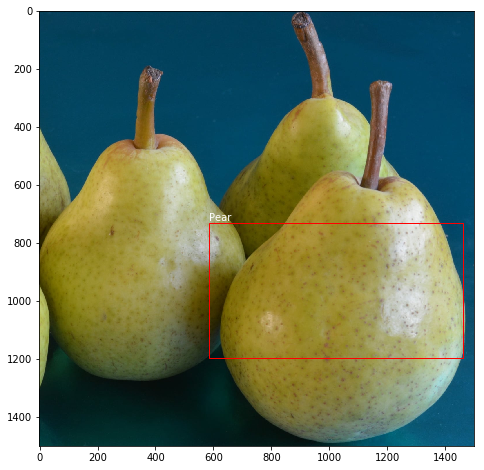

In [0]:
import matplotlib.patches as patches
tmp = np.array(image.copy()).astype('uint8')
  

fig,ax = plt.subplots(1,figsize=(16,8))
ax.imshow(image)

for i in range(0, num_classes):
  label_ = id_to_label[i]
  #print(label_)
  #plt.imshow(probabilities[:,:,i])
  #plt.show()
  if label_ != "None":
    coordinates = np.where( probabilities[:,:,i] > 0.6 ) #This needs to be varied
    if len(coordinates[0]) > 0:
      min_x = np.min(coordinates[1])
      min_y = np.min(coordinates[0])
      max_x = np.max(coordinates[1])
      max_y = np.max(coordinates[0])
      
      # Create a Rectangle patch
      rect = patches.Rectangle((min_x,min_y),max_x-min_x,max_y-min_y,linewidth=1,edgecolor='r',facecolor='none')

      ax.add_patch(rect)
      ax.text(min_x, min_y, label_,horizontalalignment='left',verticalalignment='bottom',color="White")
plt.show()